In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler


In [138]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

batch_size = 16
lookback = 16

input_size = 1
hidden_size = 8
num_stacked_layers = 2

lr = 0.0005
epochs = 50
scheduler_step_size = 1
scheduler_gamma = 0.85


In [139]:
data = pd.read_csv('AMZN.csv')
data = data[['Date', 'Close']]
#data


data['Date'] = pd.to_datetime(data['Date'])
#plt.plot(data['Date'], data['Close'])

In [140]:
def prepare_df(df, n_steps):
  df = dc(df)
  df.set_index('Date', inplace=True)

  for i in range(1, n_steps+1):
    df[f'Close(t-{i})'] = df['Close'].shift(i)

  df.dropna(inplace=True)
  return df

shifted_df = prepare_df(data, lookback)
#shifted_df

In [141]:
scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df = scaler.fit_transform(shifted_df)

#shifted_df

x = shifted_df[:, 1:]
y = shifted_df[:, 0]

#print(x.shape, y.shape)


x = dc(np.flip(x, axis = 1))  # split to train, validation and test sets:

i = int(len(x) * 0.8)
j = int(len(x) * 0.9)

x_train = x[: i]
x_val = x[i : j]
x_test = x[j :]


y_train = y[: i]
y_val = y[i : j]
y_test = y[j :]

#print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


x_train = x_train.reshape((-1, lookback, 1))  # reshape to the proper size:
x_val = x_val.reshape((-1, lookback, 1))
x_test = x_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

#print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

x_train = torch.tensor(x_train).float()  # transform from np arrays to tensors:
x_val = torch.tensor(x_val).float()
x_test = torch.tensor(x_test).float()

y_train = torch.tensor(y_train).float()
y_val = torch.tensor(y_val).float()
y_test = torch.tensor(y_test).float()

#print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


In [142]:
# Cast data to Dataset and dataloader:
class TimeSeriesDS(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, i):
    return self.x[i], self.y[i]

train_DS = TimeSeriesDS(x_train, y_train)
test_DS = TimeSeriesDS(x_test, y_test)

#train_DS

train_loader = DataLoader(train_DS, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(train_DS, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_DS, batch_size=batch_size, shuffle=False)


#for _, batch in enumerate(train_loader):
#  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
#  print(x_batch.shape, y_batch.shape)
#  break


In [143]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                        num_layers=num_stacked_layers,batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1,:])
    return out


model = LSTM(input_size, hidden_size, num_stacked_layers).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_factor)


NameError: name 'optim' is not defined

In [ ]:
def train(model,loss_func,optimizer,train_loader, val_loader, epochs):
  train_loss_arr = np.zeros(epochs)
  val_loss_arr = np.zeros(epochs)

  print('Started training')
  for epoch in range(epochs):
    running_loss_val = 0.0
    running_loss_test = 0.0

    model.train(True)
    for batch_index, batch in enumerate(train_loader):
      x_batch, y_batch = batch[0].to(device), batch[1].to(device)

      output = model(x_batch)
      loss = loss_func(output, y_batch)

      running_loss_val += loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    model.train(False)
    for batch_index, batch in enumerate(val_loader):
      x_batch, y_batch = batch[0].to(device), batch[1].to(device)

      with torch.no_grad():
        output = model(x_batch)
        loss = loss_func(output, y_batch)
        running_loss_test += loss

    running_loss_val = running_loss_val / len(train_loader)
    running_loss_test = running_loss_test / len(test_loader)
    train_loss_arr[epoch] = running_loss_val
    val_loss_arr[epoch] = running_loss_test
    print(f'Epoch {epoch + 1} finished, avarage train loss = {running_loss_val}, avarage validation loss = {running_loss_test}')
    scheduler.step()

  print('Finished training')
  return train_loss_arr, val_loss_arr

In [144]:
train_loss, val_loss = train(model, loss_func, optimizer, train_loader, val_loader, epochs)


Started training
Epoch 1 finished, avarage train loss = 0.06589755415916443, avarage validation loss = 0.08325997740030289
Epoch 2 finished, avarage train loss = 0.003953575622290373, avarage validation loss = 0.0033972361125051975
Epoch 3 finished, avarage train loss = 0.0003028875507880002, avarage validation loss = 0.0017576159443706274
Epoch 4 finished, avarage train loss = 0.00020287938241381198, avarage validation loss = 0.001461017644032836
Epoch 5 finished, avarage train loss = 0.00017838172789197415, avarage validation loss = 0.0012781257973983884
Epoch 6 finished, avarage train loss = 0.00015838220133446157, avarage validation loss = 0.0012546359794214368
Epoch 7 finished, avarage train loss = 0.00014419332728721201, avarage validation loss = 0.0010174160124734044
Epoch 8 finished, avarage train loss = 0.00012708469876088202, avarage validation loss = 0.0009423131705261767
Epoch 9 finished, avarage train loss = 0.00011551308853086084, avarage validation loss = 0.0008481595432

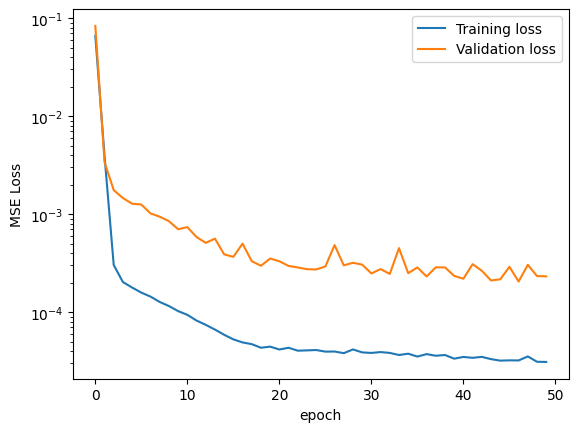

In [145]:
plt.semilogy(train_loss, label='Training loss')
plt.semilogy(val_loss, label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

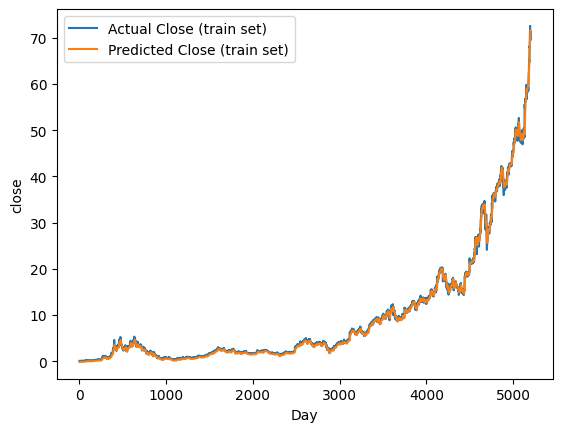

In [146]:
model.train(False)
with torch.no_grad():
  predicted_train = model(x_train.to(device)).to('cpu').numpy()

temp = np.zeros((x_train.shape[0], lookback+1))
temp[:, 0] = predicted_train.flatten()
temp = scaler.inverse_transform(temp)
predicted_train = dc(temp[:,0])

temp[:, 0] = y_train.flatten()
temp = scaler.inverse_transform(temp)
actual_train = dc(temp[:,0])

plt.plot(actual_train, label='Actual Close (train set)')
plt.plot(predicted_train, label='Predicted Close (train set)')
plt.xlabel('Day')
plt.ylabel('close')
plt.legend()
plt.show()

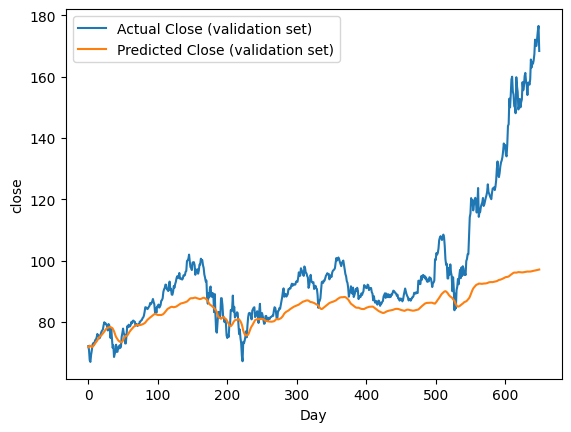

In [147]:
model.train(False)
with torch.no_grad():
  predicted_test = model(x_val.to(device)).to('cpu').numpy()

temp = np.zeros((x_val.shape[0], lookback+1))
temp[:, 0] = predicted_test.flatten()
temp = scaler.inverse_transform(temp)
predicted_val = dc(temp[:,0])

temp[:, 0] = y_val.flatten()
temp = scaler.inverse_transform(temp)
actual_val = dc(temp[:,0])

plt.plot(actual_val, label='Actual Close (validation set)')
plt.plot(predicted_val, label='Predicted Close (validation set)')
plt.xlabel('Day')
plt.ylabel('close')
plt.legend()
plt.show()